In [1]:
import numpy as np
import pandas as pd

In [2]:
dfAdmissions = pd.read_csv("../data/ADMISSIONS.csv")

dfDiagnoses = pd.read_csv("../data/DIAGNOSES_ICD.csv")

dfTitle = pd.read_csv("../data/d_icd_diagnoses.csv")

df = pd.merge(dfAdmissions, dfDiagnoses, how="inner", on=['SUBJECT_ID'])

#

#drop na values
df = df.dropna()

In [3]:
test = df.groupby('SUBJECT_ID')

test.count()

,ROW_ID_x,HADM_ID_x,ADMITTIME,DISCHTIME,DEATHTIME,ADMISSION_TYPE,ADMISSION_LOCATION,DISCHARGE_LOCATION,INSURANCE,LANGUAGE,...,ETHNICITY,EDREGTIME,EDOUTTIME,DIAGNOSIS,HOSPITAL_EXPIRE_FLAG,HAS_CHARTEVENTS_DATA,ROW_ID_y,HADM_ID_y,SEQ_NUM,ICD9_CODE
SUBJECT_ID,,,,,,,,,,,,,,,,,,,,,
109,540,540,540,540,540,540,540,540,540,540,...,540,540,540,540,540,540,540,540,540,540
111,23,23,23,23,23,23,23,23,23,23,...,23,23,23,23,23,23,23,23,23,23
188,107,107,107,107,107,107,107,107,107,107,...,107,107,107,107,107,107,107,107,107,107
250,12,12,12,12,12,12,12,12,12,12,...,12,12,12,12,12,12,12,12,12,12
275,16,16,16,16,16,16,16,16,16,16,...,16,16,16,16,16,16,16,16,16,16
304,5,5,5,5,5,5,5,5,5,5,...,5,5,5,5,5,5,5,5,5,5
353,80,80,80,80,80,80,80,80,80,80,...,80,80,80,80,80,80,80,80,80,80
433,47,47,47,47,47,47,47,47,47,47,...,47,47,47,47,47,47,47,47,47,47
502,44,44,44,44,44,44,44,44,44,44,...,44,44,44,44,44,44,44,44,44,44


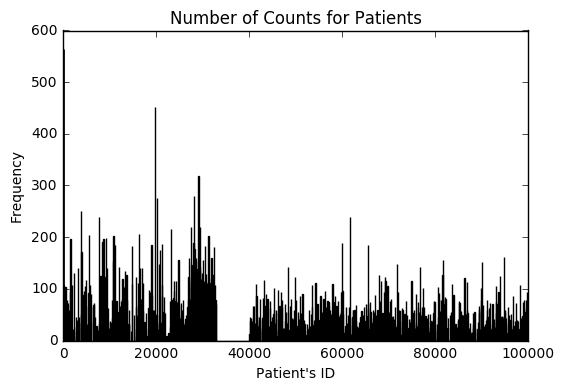

(55196, 23)

In [82]:
import matplotlib.pyplot as plt

plt.hist(df['SUBJECT_ID'] ,bins=2053)
plt.title("Number of Counts for Patients")
plt.xlabel("Patient's ID")
plt.ylabel("Frequency")

plt.show()

df.shape

In [4]:
#creating vector of HAI related to pneumonia, and HAP

hcapCode = ["48230","48231","48232","48233", "48234", "48235", "48236", "48237", "48238", 
            "48239", "48240", "4830", "4822", "4820", "48240", "48241", "48242", "48243",
           "48244", "48245", "48246", "48247", "48248", "48249", "48282", "48281", "48283",
           "48284", "48289"]

#creating boolean values that are HAI related to pneumonia, and HAP
df['is_it_HAI'] = df['ICD9_CODE'].map(lambda x: any(x == i for i in hcapCode)) 

## Total number of HAIs cases

In [5]:
len(df['SUBJECT_ID'][df['is_it_HAI']].unique())

123

## Total number of cases

In [6]:
#finding all unique subject_id
subjectID_All = df['SUBJECT_ID'].unique()

#finding the subject_id with the HAI
subjectID_HAI = df['SUBJECT_ID'][df['is_it_HAI']].unique()

#total number of cases remainding 
print(len(subjectID_All))

2053


In [7]:
#creating a dataframe
dfHAI = pd.DataFrame()
dfHAI['SUBJECT_ID'] = subjectID_HAI
dfHAI['is_it_HAI'] = 1
print('Total number of HAI cases', dfHAI.shape)

#drop duplicate
print('The shape before drop_duplicate function', df.shape)
df = df.drop_duplicates('SUBJECT_ID')
print('The shape after drop_duplicate function', df.shape)

#merge dataframes
dfFinal = pd.merge(df, dfHAI, how="left", on=['SUBJECT_ID'])
dfFinal = dfFinal.replace('NaN', 0)
print('Total number of cases', dfFinal.shape)
print('Total number of HAI Cases', dfFinal['is_it_HAI_y'].sum())

Total number of HAI cases (123, 2)
The shape before drop_duplicate function (55196, 24)
The shape after drop_duplicate function (2053, 24)
Total number of cases (2053, 25)
Total number of HAI Cases 123.0


In [8]:
#arrange office hour with someone and check this retarded shit


plt.hist(df['SUBJECT_ID'] ,bins=5000)
# plt.title("Number of Counts for Patients")
# plt.xlabel("Patient's ID")
# plt.ylabel("Frequency")

plt.show()

df.shape

import math


math.fsum(df.duplicated("SUBJECT_ID"))

NameError: name 'plt' is not defined

In [9]:
#selecting the relevant variables for logistic regression
dfFinal = dfFinal[['INSURANCE','LANGUAGE','RELIGION','MARITAL_STATUS','ETHNICITY','is_it_HAI_y']]

In [10]:
dfFinal.isnull().values.any()

False

In [11]:
#create dummy variables

dummy_insurance = pd.get_dummies(dfFinal['INSURANCE'], prefix='INSURANCE')
dummy_language = pd.get_dummies(dfFinal['LANGUAGE'], prefix = 'LANGUAGE')
dummy_religion = pd.get_dummies(dfFinal['RELIGION'], prefix = 'RELIGION')
dummy_maritalStatus = pd.get_dummies(dfFinal['MARITAL_STATUS'], prefix = 'MARITAL_STATUS')
dummy_ethnicity = pd.get_dummies(dfFinal['ETHNICITY'], prefix = 'ETHNICITY')


In [12]:
print(len(list(dummy_insurance.ix[:, 'INSURANCE_Medicaid':])) == len(list(dummy_insurance)) - 1)
print(len(list(dummy_language.ix[:, 'LANGUAGE_*AMH':])) == len(list(dummy_language)) - 1)
print(len(list(dummy_religion.ix[:, 'RELIGION_BAPTIST':])) == len(list(dummy_religion)) - 1)
print(len(list(dummy_maritalStatus.ix[:, 'MARITAL_STATUS_LIFE PARTNER':])) == len(list(dummy_maritalStatus)) - 1)
print(len(list(dummy_ethnicity.ix[:, 'ETHNICITY_AMERICAN INDIAN/ALASKA NATIVE FEDERALLY RECOGNIZED TRIBE':])) == len(list(dummy_ethnicity)) - 1)

True
True
True
True
True


In [13]:
list(dummy_insurance.ix[:, 'INSURANCE_Medicaid':])

['INSURANCE_Medicaid',
 'INSURANCE_Medicare',
 'INSURANCE_Private',
 'INSURANCE_Self Pay']

In [14]:
list(dummy_insurance)

['INSURANCE_Government',
 'INSURANCE_Medicaid',
 'INSURANCE_Medicare',
 'INSURANCE_Private',
 'INSURANCE_Self Pay']

In [15]:
#create a new data frame to fit the dummy variables
colsToKeep = ['is_it_HAI_y']
data = dfFinal[colsToKeep].join(dummy_insurance.ix[:, 'INSURANCE_Medicaid':])
data = data.join(dummy_language.ix[:, 'LANGUAGE_*AMH':])
data = data.join(dummy_religion.ix[:, 'RELIGION_BAPTIST':])
data = data.join(dummy_maritalStatus.ix[:, 'MARITAL_STATUS_LIFE PARTNER':])
data = data.join(dummy_ethnicity.ix[:, 'ETHNICITY_AMERICAN INDIAN/ALASKA NATIVE FEDERALLY RECOGNIZED TRIBE':])

In [16]:
#logistic regression

from sklearn.linear_model import LogisticRegression

logistic = LogisticRegression()

train_cols = data.columns[1:]

logitModel = logistic.fit(data[train_cols], data['is_it_HAI_y'])

In [17]:
# examine 88 the coefficients(including intercept)

k=0
for i in train_cols:
    print(i, logitModel.coef_[0][k])
    k += 1
    

INSURANCE_Medicaid 0.00522809988187
INSURANCE_Medicare 0.169473296641
INSURANCE_Private -0.137575159239
INSURANCE_Self Pay -0.632111181432
LANGUAGE_*AMH -0.0417157303107
LANGUAGE_*ARM -0.206412156145
LANGUAGE_*BEN -0.0608391977724
LANGUAGE_*BUR -0.0468421456168
LANGUAGE_*CDI -0.10089128718
LANGUAGE_*FUL -0.0715525191102
LANGUAGE_*GUJ -0.0578767244192
LANGUAGE_*HUN -0.10089128718
LANGUAGE_*RUS -0.126577300148
LANGUAGE_*TOY 0.863297288223
LANGUAGE_*YID -0.14878651788
LANGUAGE_ALBA 0.867585624775
LANGUAGE_AMER 0.713249053253
LANGUAGE_CAMB -0.0892367357907
LANGUAGE_CANT 0.181114482159
LANGUAGE_CAPE -0.0355244412685
LANGUAGE_ENGL -0.37708599061
LANGUAGE_FREN -0.238244971865
LANGUAGE_GREE -0.591055075177
LANGUAGE_HAIT 0.264841908019
LANGUAGE_HIND -0.13160019232
LANGUAGE_ITAL -0.384983691994
LANGUAGE_JAPA -0.0450879520683
LANGUAGE_KORE -0.167545842962
LANGUAGE_LAOT -0.0698096501536
LANGUAGE_MAND -0.0849080780991
LANGUAGE_PERS 1.19173572096
LANGUAGE_POLI -0.166256322114
LANGUAGE_PORT -0.084330

In [18]:
#predict the training set accuracy rate

print("Training set accuracy rate", logitModel.score(data[train_cols], data['is_it_HAI_y']))


Training set accuracy rate 0.940087676571


In [19]:
#split into training and testing data set

split = np.random.rand(len(data)) < 0.5

test = data[split]

train = data[~split]


In [20]:
#training data

logitModel = logistic.fit(train[train_cols], train['is_it_HAI_y'])

#predict the training set accuracy rate

print("Training set accuracy rate", logitModel.score(train[train_cols], train['is_it_HAI_y']))

Training set accuracy rate 0.934762348555


In [66]:
def true_positive_rate(confusion_matrix):
    """ Find the true positive rate from the confusion matrix
    Parameters
    ----------
    confusion_matrix : 4 x 4 matrix with true positive, true negative, false positive, false negative

    Returns
    -------     
    float type, with true positive rate

    """
    
    true_positive = confusion_matrix[1][1]
    condition_positive = confusion_matrix[1][0] + confusion_matrix[1][1]
    
    return true_positive/condition_positive

def false_positive_rate(confusion_matrix):
    """ Find the false positive rate from the confusion matrix
    Parameters
    ----------
    confusion_matrix : 4 x 4 matrix with true positive, true negative, false positive, false negative

    Returns
    -------     
    float type, with false positive rate

    """
    
    false_positive = confusion_matrix[0][1]
    condition_positive = confusion_matrix[0][0] + confusion_matrix[0][1]
    
    return false_positive/condition_positive



In [68]:
from sklearn.metrics import confusion_matrix

confMatrix = confusion_matrix(train['is_it_HAI_y'], logitModel.predict(train[train_cols]))

true_positive_rate(confMatrix)
false_positive_rate(confMatrix)

0.0

In [21]:
#predict the test set accuracy rate

print("Testing set accuracy rate", logitModel.score(test[train_cols], test['is_it_HAI_y']))

Testing set accuracy rate 0.945918367347


In [69]:
from sklearn.metrics import confusion_matrix

confMatrix = confusion_matrix(test['is_it_HAI_y'], logitModel.predict(test[train_cols]))

true_positive_rate(confMatrix)
false_positive_rate(confMatrix)

0.0

# Preliminary Analysis

<img src="https://i.stack.imgur.com/CRZGo.png">

Since our testing set accuracy rate is higher than our training set, we can add more features to lower down the test and training error.

## ROC Curve

Need to check with professor regarding the optimal trade off point.

The issue here is that by identifying as many people from the HAI group(increasing true posiive rate), more health people will be incorrectly identified(increasing false positive rate). The trade off is that by increasing the true positive rate, we will also increase false positive rate(even though we want the false positive rate to go down). As such, the ROC curve will help us identify a sweet spot, an optimal point.



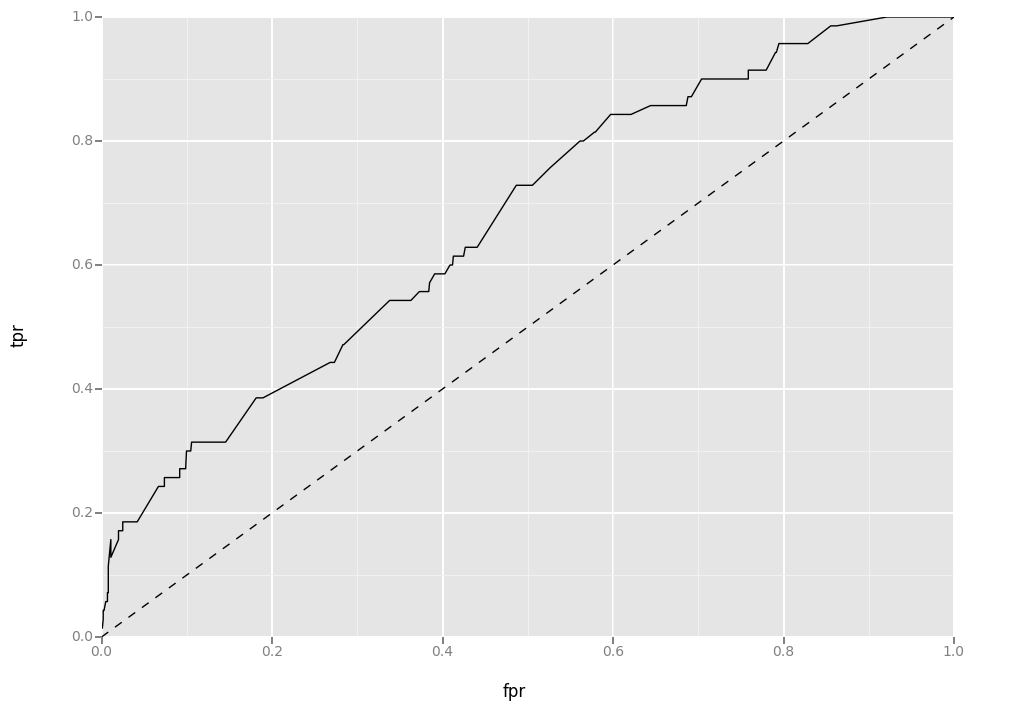

<ggplot: (-9223372036565105222)>

In [24]:
from sklearn import metrics
from ggplot import *

preds = logitModel.predict_proba(train[train_cols])[:,1]
fpr, tpr, _ = metrics.roc_curve(train['is_it_HAI_y'], preds)

df = pd.DataFrame(dict(fpr=fpr, tpr=tpr))
ggplot(df, aes(x='fpr', y='tpr')) +\
    geom_line() +\
    geom_abline(linetype='dashed')


## Finding the optimal probability that corresponds to the sweet spot on the ROC curve

In [72]:
def Find_Optimal_Cutoff(target, predicted):
    """ Find the optimal probability cutoff point for a classification model related to event rate
    Parameters
    ----------
    target : Matrix with dependent or target data, where rows are observations

    predicted : Matrix with predicted data, where rows are observations

    Returns
    -------     
    list type, with optimal cutoff value

    """
    fpr, tpr, threshold = metrics.roc_curve(target, predicted)
    i = np.arange(len(tpr)) 
    roc = pd.DataFrame({'tf' : pd.Series(tpr-(1-fpr), index=i), 'threshold' : pd.Series(threshold, index=i)})
    roc_t = roc.ix[(roc.tf-0).abs().argsort()[:1]]

    return list(roc_t['threshold']) 

# Add prediction probability to dataframe
train['pred_proba'] = preds

# Find optimal probability threshold
threshold = Find_Optimal_Cutoff(train['is_it_HAI_y'],  preds)
print("The cutoff probability is", threshold[0])
# [0.31762762459360921]

# Find prediction to the dataframe applying threshold
train['pred'] = train['pred_proba'].map(lambda x: 1 if x > float(threshold[0]) else 0)

# Print confusion Matrix
from sklearn.metrics import confusion_matrix

confMatrix = confusion_matrix(train['is_it_HAI_y'], train['pred'])
# array([[175,  98],
#        [ 46,  81]])

print("The true positive rate is", true_positive_rate(confMatrix))
print("The false positive rate is", false_positive_rate(confMatrix))

The cutoff probability is 0.0685289281817
The true positive rate is 0.585714285714
The false positive rate is 0.402791625125


/Users/tankaiwei/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/tankaiwei/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


## Finding the sweet spot 

In [73]:
# Add prediction probability to dataframe
preds = logitModel.predict_proba(test[train_cols])[:,1]
test['pred_proba'] = preds

# Find optimal probability threshold
threshold = Find_Optimal_Cutoff(test['is_it_HAI_y'],  preds)
print("The cutoff probability is", threshold[0])
# [0.31762762459360921]

# Find prediction to the dataframe applying threshold
test['pred'] = test['pred_proba'].map(lambda x: 1 if x > float(threshold[0]) else 0)

# Print confusion Matrix
from sklearn.metrics import confusion_matrix

confMatrix = confusion_matrix(test['is_it_HAI_y'], test['pred'])
# array([[175,  98],
#        [ 46,  81]])

print("The true positive rate is", true_positive_rate(confMatrix))
print("The false positive rate is", false_positive_rate(confMatrix))


The cutoff probability is 0.061899073014
The true positive rate is 0.509433962264
The false positive rate is 0.453074433657


/Users/tankaiwei/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
/Users/tankaiwei/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


## Cost sensitive learning